In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import warnings
warnings.filterwarnings('ignore')

Import nyc shape file and alcohol licenses data.

In [2]:
nyc_map = gpd.read_file('Data/raw/nyc_shape.geojson')
nyc_map.rename(columns={'ZIPCODE':'ZIP'}, inplace=True)

manh_map = nyc_map[nyc_map.COUNTY.isin(['New York'])]
brook_map = nyc_map[nyc_map.COUNTY=='Kings']


In [3]:
lic_data = pd.read_csv('Data/Processed/nyc_licenses.csv', dtype={'ZIP':object})
lic_per_zip = (lic_data.groupby('ZIP')['Serial Number'].count()
               .reset_index().rename(columns={'Serial Number':'# LICENSES'}))
# There are some odd ZIPs but they will be dropped in a future merge

In [4]:
#merge counts into shapefiles
manh = manh_map.merge(lic_per_zip, on='ZIP', how='left')
brook = brook_map.merge(lic_per_zip, on='ZIP', how='left')
nyc = nyc_map.merge(lic_per_zip, on='ZIP', how='left')

### Get stations data

Import and convert to GeoDataFrame

In [5]:
stations = pd.read_csv('Data/Processed/totals_geo_21.csv', dtype={'ZIP':object})
stations.dropna(subset=['the_geom'], inplace=True)
# Convert into well known text, as instructed by 'Geowiz34', otherwise I get TypeError
# idk why this happens, they are still 'object' type
stations['the_geom'] = stations['the_geom'].apply(wkt.loads)
#Convert Pandas df into Geopandas df
stations = gpd.GeoDataFrame(stations, geometry='the_geom')

In [6]:
stations[stations.STATION=='1 AV']

,STATION,TOTAL_ENTRIES,ZIP,BOROUGH,the_geom
0,1 AV,523393.0,10009,Manhattan,POINT (-73.98168 40.73097)


Normalize total_entrances column so we can plot the stations with different sizes.

In [7]:
manh_stations = stations[stations.BOROUGH=='Manhattan']
entries = manh_stations.TOTAL_ENTRIES
manh_stations['SCALED_ENTRIES'] = ((entries - entries.min())/(entries.max()-entries.min())*350)

brook_stations = stations[stations.BOROUGH=='Brooklyn']
entries = brook_stations.TOTAL_ENTRIES
brook_stations['SCALED_ENTRIES'] = ((entries - entries.min())/(entries.max()-entries.min())*300)

entries = stations.TOTAL_ENTRIES
stations['SCALED_ENTRIES'] = ((entries - entries.min())/(entries.max()-entries.min())*200)

Functions for map annotations

In [8]:
#(test.apply(lambda x: ax.annotate(s=x.ZIPCODE, color='black', 
#                                  xy=x.geometry.centroid.coords[0],ha='center'), axis=1))
def busy_stations(x, top_stations, size=10):
    label = 0
    for i in top_stations:
        if x['STATION'] == i:
            label = x.STATION
    if label == 0:
        return None
    return (ax.annotate(s=label, color='black', 
                        xy=x.the_geom.centroid.coords[0], ha='center',
                       fontweight='bold', size=size))
top_manh_stat = ['14 ST-UNION SQ','50 ST', '2 AV','7 AV']
top_brook_stat = ['DEKALB AV','JAY ST-METROTEC','BEDFORD AV']

def party_zips(x, top_zips, size=10):
    label = 0
    for i in top_zips:
        if x['ZIP'] == i:
            label = x.ZIP
    if label == 0:
        return None
    return (ax.annotate(s=label, color='black', 
                        xy=x.geometry.centroid.coords[0], ha='center',
                       fontweight='bold', size=size))

def all_stations(x, size=10):
    label = x.STATION
    return (ax.annotate(s=label, color='black', 
                        xy=x.the_geom.centroid.coords[0], ha='center',
                       fontweight='bold', size=size))
boozy_manh_zips = ['10019','10003','10036']
boozy_brook_zips = ['11211','11201','11215']

### Plot

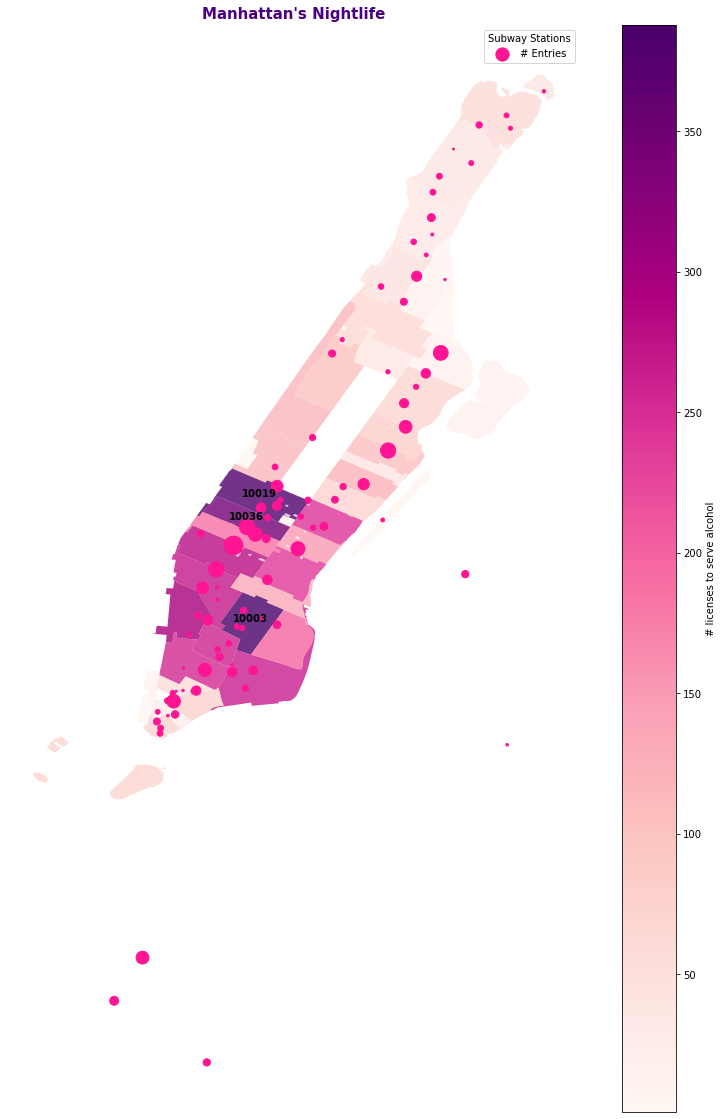

In [9]:
#Plot the count by ZIP into a map
fig,ax = plt.subplots(1,1, figsize=(15,20))
#plt.figure(figsize=(15, 10))
manh.plot(column='# LICENSES', cmap='RdPu', alpha=.8, ax=ax, legend=True,
          legend_kwds={'label': "# licenses to serve alcohol"})
manh.apply(party_zips, axis=1, top_zips=boozy_manh_zips)
manh_stations.plot(markersize='SCALED_ENTRIES', color='deeppink',ax=ax, label='# Entries')
plt.title("Manhattan's Nightlife", size=15, family='sans-serif', color='indigo', fontweight='bold')
plt.legend(title='Subway Stations')
plt.axis('off')
plt.savefig('Visualizations/manh_map.png', bbox_inches='tight')


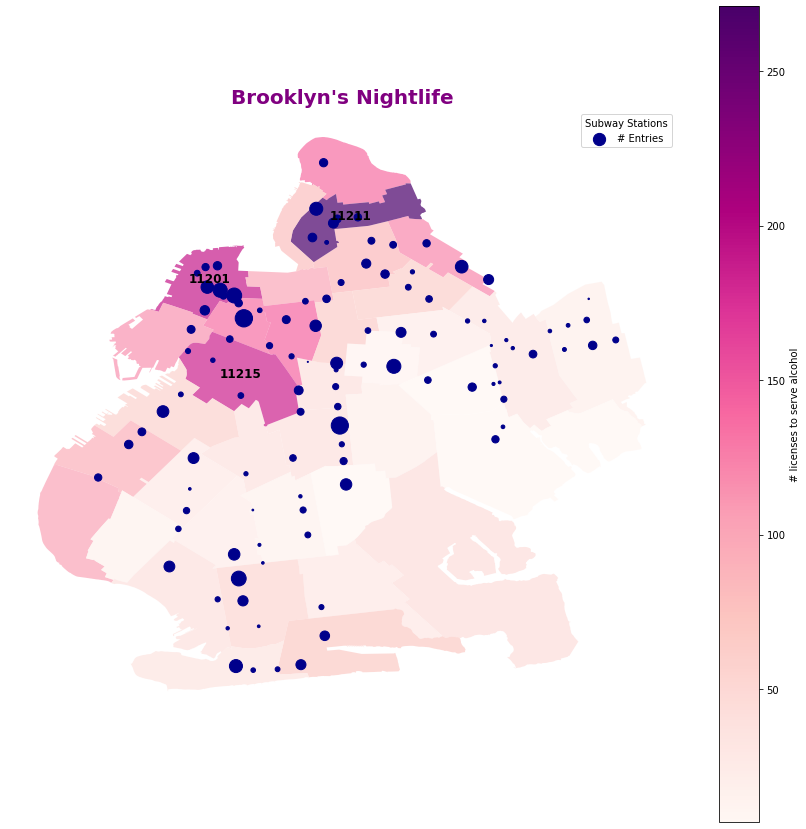

In [29]:
fig,ax = plt.subplots(1,1, figsize=(15,15))
plt.ylabel('# Alcohol Licenses', size=20)
(brook.plot(column='# LICENSES', cmap='RdPu', alpha=.7, ax=ax, legend=True,
            legend_kwds={'label': "# licenses to serve alcohol"}))

brook_stations.plot(markersize='SCALED_ENTRIES', color='darkblue',ax=ax, label='# Entries')
brook.apply(party_zips, axis=1, top_zips=boozy_brook_zips, size=12)
plt.legend(title='Subway Stations')
plt.title("Brooklyn's Nightlife", size=20, color='purple', fontweight='bold')
ax.yaxis.set_label_position("right")
plt.axis('off')
plt.savefig('Visualizations/brook_map.png', bbox_inches='tight')



In [11]:
boozy_manh_st = manh_stations[manh_stations.ZIP.isin(boozy_manh_zips)].reset_index(drop=True)
boozy_brook_st = brook_stations[brook_stations.ZIP.isin(boozy_brook_zips)].reset_index(drop=True)

boozy_manh = manh[manh.ZIP.isin(boozy_manh_zips)].reset_index(drop=True)
boozy_brook = brook[brook.ZIP.isin(boozy_brook_zips)].reset_index(drop=True)


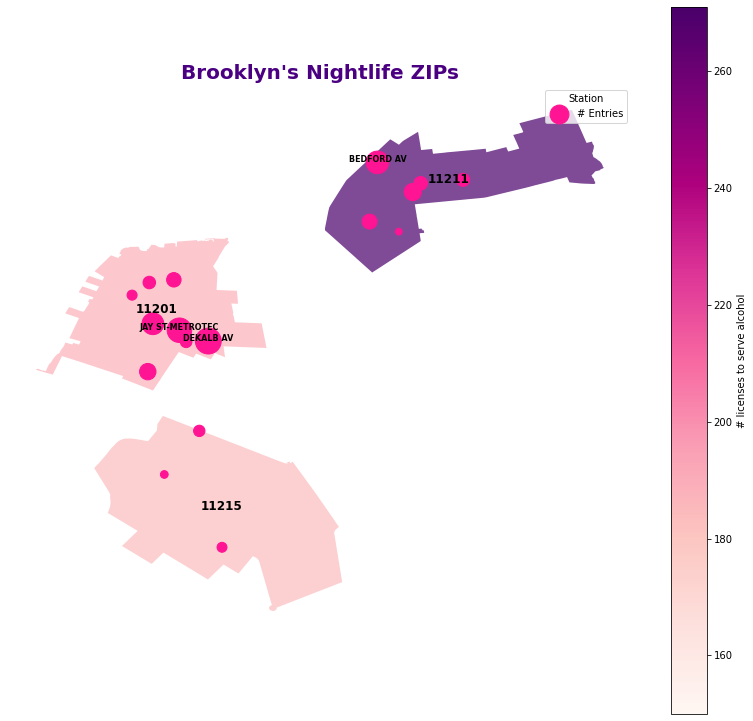

In [26]:
#Plot boozy brooklyn
fig,ax = plt.subplots(1,1, figsize=(14,13))
boozy_brook_st['NEW_ENTRIES'] = boozy_brook_st['SCALED_ENTRIES']*3

(boozy_brook.plot(column='# LICENSES', cmap='RdPu', alpha=.7, ax=ax, 
                  legend=True,legend_kwds={'label': "# licenses to serve alcohol"}, vmin=150))
boozy_brook_st.plot(markersize='NEW_ENTRIES', color='deeppink',ax=ax, label='# Entries')
brook_stations.apply(busy_stations, axis=1, top_stations=top_brook_stat, size=8)
brook.apply(party_zips, axis=1, top_zips=boozy_brook_zips, size=12)
plt.legend(title='Station')
plt.title("Brooklyn's Nightlife ZIPs", size=20, color='indigo', fontweight='bold')
plt.axis('off')
plt.savefig('Visualizations/brook_zoom.png', bbox_inches='tight')

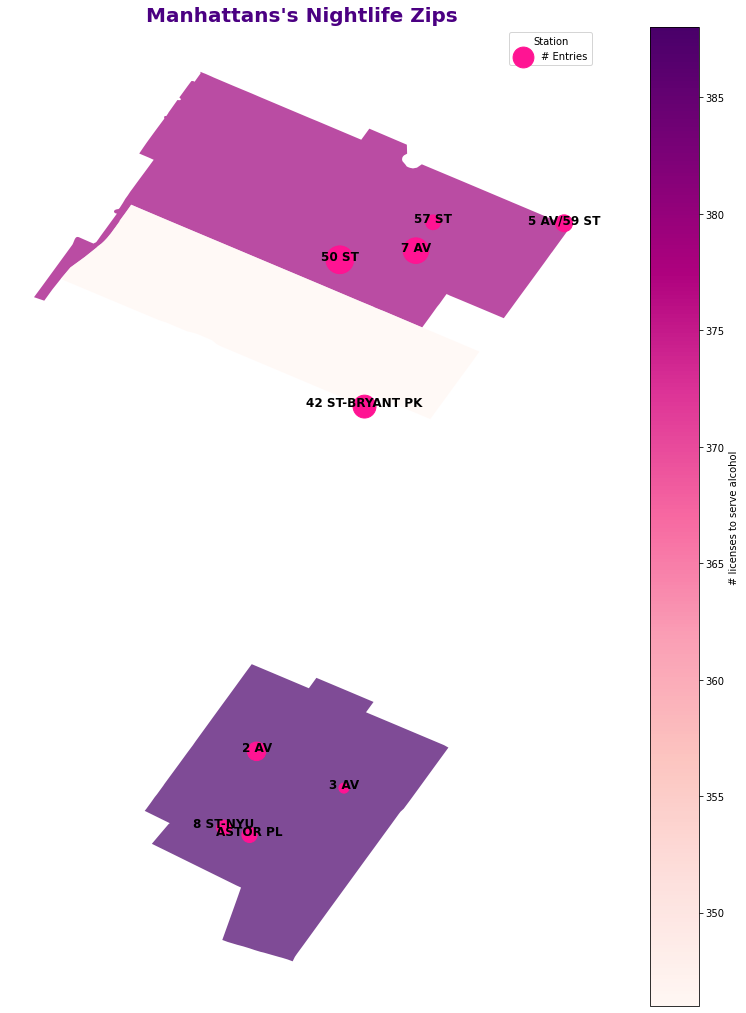

In [28]:
#Plot boozy manhattan
fig,ax = plt.subplots(1,1, figsize=(19,18))
boozy_manh_st['NEW_ENTRIES'] = boozy_manh_st['SCALED_ENTRIES']*8

(boozy_manh.plot(column='# LICENSES', cmap='RdPu', alpha=.7,
                 ax=ax, legend=True, legend_kwds={'label': "# licenses to serve alcohol"}))
boozy_manh_st.plot(markersize='NEW_ENTRIES', color='deeppink',ax=ax, label='# Entries')
boozy_manh_st.apply(all_stations, axis=1, size=12)
plt.legend(title='Station')
plt.title("Manhattans's Nightlife Zips", size=20, color='indigo', fontweight='bold')
plt.axis('off')
plt.savefig('Visualizations/manh_zoom.png', bbox_inches='tight')

In [ ]:
plt.subplot(1,3,1)
stations[stations.ZIP=='10019'].loc[:,''.plot()
#boozy_manh_st.plot(markersize='SCALED_ENTRIES', color='navy',ax=ax, label='Station')
#boozy_manh_st.apply(all_stations, axis=1, size=20)
plt.legend(title='Subway Entries')
plt.title("Number of Licenses per Brooklyn ZIP", size=20, color='purple', fontweight='bold')
plt.axis('off')

In [ ]:
nyc_map[nyc_map.ZIP=='10019']

In [ ]:
my_zips = ['10019','10003','10036','11211','11201','11215']
brook_stations[brook_stations.ZIP==my_zips[3]].total_bounds

In [ ]:
lic_geo = pd.read_csv('Data/Processed/nyc_lic_geo.csv')

In [ ]:
lic_geo.info()

In [ ]:
#lic_geo = pd.read_csv('Data/Processed/nyc_lic_geo.csv')
# Convert into well known text, as instructed by 'Geowiz34', otherwise I get TypeError
# idk why this happens, they are still 'object' type
#lic_geo['Georeference'] = stations['Georeference'].apply(wkt.loads)
#Convert Pandas df into Geopandas df
#lic_geo = gpd.GeoDataFrame(lic_geo, geometry='Georeference')

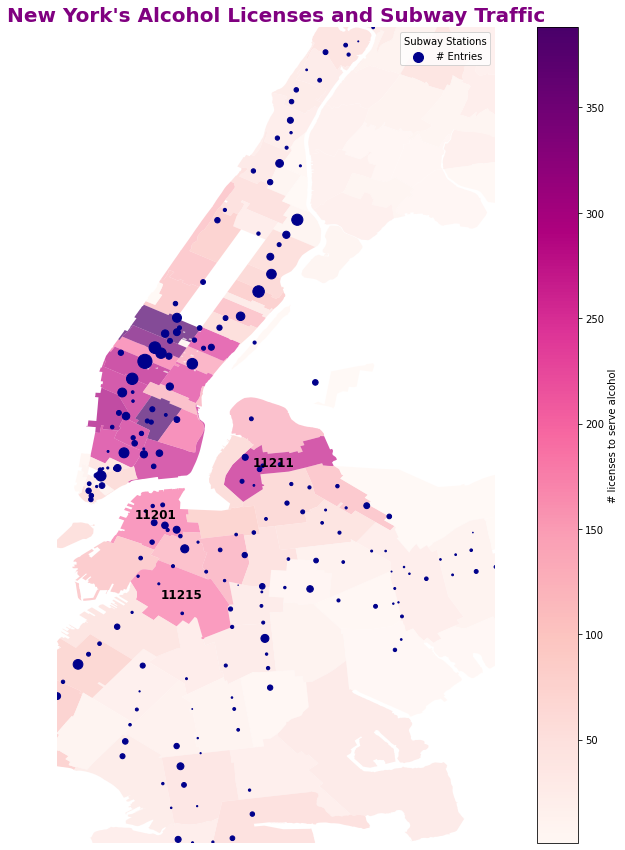

In [25]:
minx, miny, maxx, maxy = stations.total_bounds


fig,ax = plt.subplots(1,1, figsize=(15,15))
plt.ylabel('# Alcohol Licenses', size=20)
(nyc.plot(column='# LICENSES', cmap='RdPu', alpha=.7, ax=ax, legend=True,
            legend_kwds={'label': "# licenses to serve alcohol"}))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
stations.plot(markersize='SCALED_ENTRIES', color='darkblue',ax=ax, label='# Entries')
nyc.apply(party_zips, axis=1, top_zips=boozy_brook_zips, size=12)
plt.legend(title='Subway Stations')
plt.title("New York's Alcohol Licenses and Subway Traffic", size=20, color='purple', fontweight='bold')
ax.yaxis.set_label_position("right")
plt.axis('off')
plt.savefig('Visualizations/nyc_map.png', bbox_inches='tight')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True)

nyc_map[nyc_map.ZIP=='10019'].plot(ax=ax1)
brook_stations[brook_stations.ZIP==my_zips[3]].apply(all_stations, axis=1, ax=ax1)
#boozy_manh_st.apply(all_stations, axis=1, size=20)
#ax1.legend(title='Subway Entries')
#ax1.title("10019", size=20, color='purple', fontweight='bold')
ax1.axis('off')


nyc_map[nyc_map.ZIP=='10003'].plot(ax=ax2)
brook_stations[brook_stations.ZIP==my_zips[4]].apply(all_stations, axis=1)
#boozy_manh_st.plot(markersize='SCALED_ENTRIES', color='navy',ax=ax, label='Station')
#boozy_manh_st.apply(all_stations, axis=1, size=20)
#ax2.legend(title='10003')
#plt.title("Number of Licenses per Brooklyn ZIP", size=20, color='purple', fontweight='bold')
ax2.axis('off')


nyc_map[nyc_map.ZIP=='10036'].plot(ax=ax3)
brook_stations[brook_stations.ZIP==my_zips[5]].apply(all_stations, axis=1)
#boozy_manh_st.plot(markersize='SCALED_ENTRIES', color='navy',ax=ax, label='Station')
#boozy_manh_st.apply(all_stations, axis=1, size=20)
#ax3.legend(title='10036')
#plt.title("Number of Licenses per Brooklyn ZIP", size=20, color='purple', fontweight='bold')
ax3.axis('off')
